## Time Series Analysis

### Preprocessing

In [ ]:
import os
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
working_dir = os.path.join(Path(os.getcwd()), "drive", "My Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Converting mat files to csv.
mat files have to be downloaded.
csv files are stored in '/content/drive/My Drive/data/csv/raw' directory.

In [ ]:
import csv
import scipy.io
from datetime import datetime

def get_mat_file_names():
    mat_path = os.path.join(working_dir, "data", "mat")
    file_names = sorted(os.listdir(mat_path))

    for i in range(len(file_names)):
        file_names[i] = os.path.join(mat_path, file_names[i])

    return file_names


def get_mat_file(mat_file_name):
    return scipy.io.loadmat(mat_file_name)['CF'][0][0]


def get_day_data(mat_file):
    return mat_file[0]


def get_tensions_by_index(mat_file, index):
    day_data = get_day_data(mat_file)
    tensions = []
    for elem in day_data:
        tensions.append(elem[index])
    return tensions


def get_cables(mat_file):
    return mat_file[1][0]


def get_cable_name_by_index(mat_file, index):
    cables = get_cables(mat_file)
    return cables[index][0]

In [ ]:
# get matlab files and extracting dates and cable names
mat_files = [get_mat_file(mat_file_name) for mat_file_name in get_mat_file_names()]
str_dates = [mat_file_name[len(mat_file_name)-14:-4] for mat_file_name in get_mat_file_names()]
dates = [datetime.strptime(str_date, "%Y-%m-%d") for str_date in str_dates]
cables = [get_cable_name_by_index(mat_files[0], i) for i in range(14)]

# extracting cable tension values
values_by_date = []
for mat_file in mat_files:
    value = [get_tensions_by_index(mat_file, index) for index in range(14)]
    values_by_date.append(value)
    
# making directory for saving csv dataset
csv_path = os.path.join(working_dir, "data", "csv", "raw")
Path(csv_path).mkdir(parents=True, exist_ok=True)
    
# saving csv file by date
for i, str_date in enumerate(str_dates):
    filename = str_date + '.csv'
    filepath = os.path.join(csv_path, filename)
    with open(filepath, 'w', newline='') as f:
        print("converting mat file into csv:", filepath)
        writer = csv.writer(f)

        writer.writerow(cables)
        value = values_by_date[i]
        for j in range(172800):
            row = []
            for k in range(14):
                row.append(value[k][j])
            writer.writerow(row)

converting mat file into csv: /content/drive/My Drive/data/csv/raw/2006-05-13.csv
converting mat file into csv: /content/drive/My Drive/data/csv/raw/2006-05-14.csv
converting mat file into csv: /content/drive/My Drive/data/csv/raw/2006-05-15.csv
converting mat file into csv: /content/drive/My Drive/data/csv/raw/2006-05-16.csv
converting mat file into csv: /content/drive/My Drive/data/csv/raw/2006-05-17.csv
converting mat file into csv: /content/drive/My Drive/data/csv/raw/2006-05-18.csv
converting mat file into csv: /content/drive/My Drive/data/csv/raw/2006-05-19.csv
converting mat file into csv: /content/drive/My Drive/data/csv/raw/2007-12-14.csv
converting mat file into csv: /content/drive/My Drive/data/csv/raw/2009-05-05.csv
converting mat file into csv: /content/drive/My Drive/data/csv/raw/2011-11-01.csv


#### Removing outliers in csv files.
saving results in '/content/drive/My Drive/data/csv/preprocessed'

In [ ]:
import pandas as pd
import numpy as np

data_list=[]
X = []

# preprocessing
dates_to_preprocess = ['2007-12-14','2009-05-05','2011-11-01']
for str_date in str_dates:
    filename = os.path.join(csv_path, str_date + '.csv')
    data = pd.read_csv(filename)
    if str_date in dates_to_preprocess:
        q25,q75=np.quantile(data['SJS13'],[0.25,0.75])
        print(q25-1.5*(q75-q25),q75+1.5*(q75-q25))
        data['SJS13'][data['SJS13']<q25-1.5*(q75-q25)]=np.nan
        data['SJS13'][data['SJS13']>q75+1.5*(q75-q25)]=np.nan
    data=data.interpolate(method='linear')
    data=data.iloc[90:-90]
    data_list.append(data)
    X.append(data.values)
X=np.concatenate(X,axis=0)

# saving results
length = int(X.shape[0] / 10)
pre_path = os.path.join(working_dir, "data", "csv", "preprocessed")
Path(pre_path).mkdir(parents=True, exist_ok=True)

for i, str_date in enumerate(str_dates):
    filename = os.path.join(pre_path, str_date + '.csv')
    print("saving", filename)
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)

        writer.writerow(cables)
        for j in range(i*length, (i*length)+length):
            row = []
            for k in range(14):
                row.append(X[j][k])
            writer.writerow(row)

2774.862492801036 2860.8972732559014
2785.931150398128 2869.0900732652844
2732.015028449452 2869.1944270294844
saving /content/drive/My Drive/data/csv/preprocessed/2006-05-13.csv
saving /content/drive/My Drive/data/csv/preprocessed/2006-05-14.csv
saving /content/drive/My Drive/data/csv/preprocessed/2006-05-15.csv
saving /content/drive/My Drive/data/csv/preprocessed/2006-05-16.csv
saving /content/drive/My Drive/data/csv/preprocessed/2006-05-17.csv
saving /content/drive/My Drive/data/csv/preprocessed/2006-05-18.csv
saving /content/drive/My Drive/data/csv/preprocessed/2006-05-19.csv
saving /content/drive/My Drive/data/csv/preprocessed/2007-12-14.csv
saving /content/drive/My Drive/data/csv/preprocessed/2009-05-05.csv
saving /content/drive/My Drive/data/csv/preprocessed/2011-11-01.csv


### Applying STL decomposition

In [ ]:
from datetime import timedelta
from statsmodels.tsa.seasonal import STL
import time

def get_tensions_by_index_and_date(cable_index, str_date):
    filename = os.path.join(pre_path, str_date +".csv")

    with open(filename, 'r') as file:
        reader = csv.reader(file)
        original = []
        for i, row in enumerate(reader):
            if i == 0: continue
            original.append(float(row[cable_index]))
        return original
    
def write_single_stl(str_date, cable_name, stl_df):
    headers = ['original', 'trend', 'seasonal', 'remainder']

    filepath = os.path.join(working_dir, "data", "stl", "period%d" % period, str_date)
    Path(filepath).mkdir(parents=True, exist_ok=True)
    
    filename = str_date + "-" + cable_name + ".csv"
    filepath = os.path.join(filepath, filename)
    print("saving", filepath)
    with open(filepath, 'w', newline='') as f:
        writer = csv.writer(f)

        writer.writerow(headers)
        value = stl_df
        for j in range(length):
            row = []
            row.append(value['original'].iloc[j:j + 1].values[0])
            row.append(value['trend'].iloc[j:j + 1].values[0])
            row.append(value['seasonal'].iloc[j:j + 1].values[0])
            row.append(value['remainder'].iloc[j:j + 1].values[0])
            writer.writerow(row)
            
def get_stl_df(value, period):
    stl = STL(value, period=period).fit()
    trend = stl.trend.to_numpy()
    seasonal = stl.seasonal.to_numpy()
    remainder = stl.resid.to_numpy()
    stl_df = pd.DataFrame({"original": value, "trend": trend,
                           "seasonal": seasonal, "remainder": remainder})
    return stl_df

def get_single_stl(mat_file, str_date, cable_index, period, trim_first=0, trim_end=length):
    cable_name = get_cable_name_by_index(mat_file, cable_index)
    print("get_single_stl %s %s, %s" % (str_date, cable_name, str(time.time())))
    periods = trim_end - trim_first
    starting_time = datetime.strptime(str_date, "%Y-%m-%d") + timedelta(seconds=(trim_first+90)*0.5)
    value = get_tensions_by_index_and_date(cable_index, str_date)
    value = pd.Series(value[trim_first:trim_end],
                      index=pd.date_range(starting_time, periods=periods, freq='500ms'),
                      name=str_date)
    stl_df = get_stl_df(value, period)
    write_single_stl(str_date, cable_name, stl_df)
    return stl_df

def get_day_stl(date_index, period):
    mat_file_name = get_mat_file_names()[date_index]
    print("get_day_stl %s, %s" % (mat_file_name, str(time.time())))
    mat_file = get_mat_file(mat_file_name)
    str_date = mat_file_name[:-4]
    str_date = str_date[len(str_date)-10:]

    date = datetime.strptime(str_date, "%Y-%m-%d")
    cable_names = [get_cable_name_by_index(mat_file, i) for i in range(14)]
    stl_values = [get_single_stl(mat_file, str_date, cable_index, period) for cable_index in range(14)]

    return date, cable_names, stl_values

def get_all_stl(period):
    day_stl_list = [get_day_stl(i, period) for i in range(10)]
    return day_stl_list

In [ ]:
# set interval period as 3600
# this code takes long time. the result is saved in '/data/stl'
period = 3600
stl_list = get_all_stl(period)

### Plot results

In [ ]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import enum

class STLType(enum.Enum):
    ORIGINAL = 0
    TREND = 1
    SEASONAL = 2
    REMAINDER = 3

def plot_single_stl(stl, date, cable_name, start=0, end=length, fig_height=4):
    x_value = [date + timedelta(seconds=i * 0.5) + timedelta(seconds=(start + 90) * 0.5) for i in range(end - start)]
    x_format = mdates.DateFormatter('%H:%M')

    plt.rcParams.update({'font.size': 35})

    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(80, 15 * fig_height))
    plt.suptitle("%s, %s" % (date.strftime("%Y-%m-%d"), cable_name), fontsize=70)
    fig.tight_layout(pad=5)
    for i, ax in enumerate(axs):
        ax.plot(x_value, stl.iloc[start:end, i])
        ax.set(ylabel=stl.iloc[start:end, i].name)
        ax.xaxis.set_major_formatter(x_format)
        
def plot_cable_stl_by_type(period, cable_index, stl_type, date_index_list=[i for i in range(10)], start=0, end=length):
    str_dates, cable_name, stl_df_list = read_cable_stl(period, cable_index)
    date = datetime.strptime(str_dates[0], "%Y-%m-%d")
    x_value = [date + timedelta(seconds=(start + 90 + i) * 0.5) for i in range(end - start)]

    y_values = {}
    for i in date_index_list:
        value = stl_df_list[i][start:end][STLType(stl_type).name.lower()].to_numpy()
        y_values[str_dates[i]] = value

    plt.rcParams.update({'font.size': 35})
    plt.figure(figsize=(80, 15))
    for i in date_index_list:
        plt.plot(x_value, y_values[str_dates[i]], label=str_dates[i])

    plt.suptitle("%s %s" % (cable_name, STLType(stl_type).name))
    plt.legend()
    plt.show()
    
def read_cable_stl(period, cable_index):
    cable_name = ""
    dates = []
    stl_df_list = []
    for i in range(10):
        date, cable_name, stl_df = read_single_stl(period, i, cable_index)
        dates.append(date)
        stl_df_list.append(stl_df)

    return dates, cable_name, stl_df_list

def read_csv_stl_list(filename):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        original = []
        trend = []
        seasonal = []
        remainder = []
        for i, row in enumerate(reader):
            if i == 0: continue
            original.append(float(row[0]))
            trend.append(float(row[1]))
            seasonal.append(float(row[2]))
            remainder.append(float(row[3]))
        stl_df = pd.DataFrame({"original": original, "trend": trend, "seasonal": seasonal, "remainder": remainder})
        return stl_df

def read_and_plot_single_stl(period, date_index, cable_index):
    str_date, cable_name, stl_df = read_single_stl(period, date_index, cable_index)
    date = datetime.strptime(str_date, "%Y-%m-%d")
    plot_single_stl(stl_df, date, cable_name)
    
def read_single_stl(period, date_index, cable_index):
    csv_path = os.path.join(working_dir, "data", "stl", "period%d" % period)
    filename = sorted(os.listdir(csv_path))[date_index]
    csv_path = os.path.join(csv_path, filename)

    date = sorted(os.listdir(csv_path))[cable_index][:10]
    cable_name = sorted(os.listdir(csv_path))[cable_index][11:-4]
    csv_path += "/%s" % sorted(os.listdir(csv_path))[cable_index]
    stl_df = read_csv_stl_list(csv_path)

    return date, cable_name, stl_df

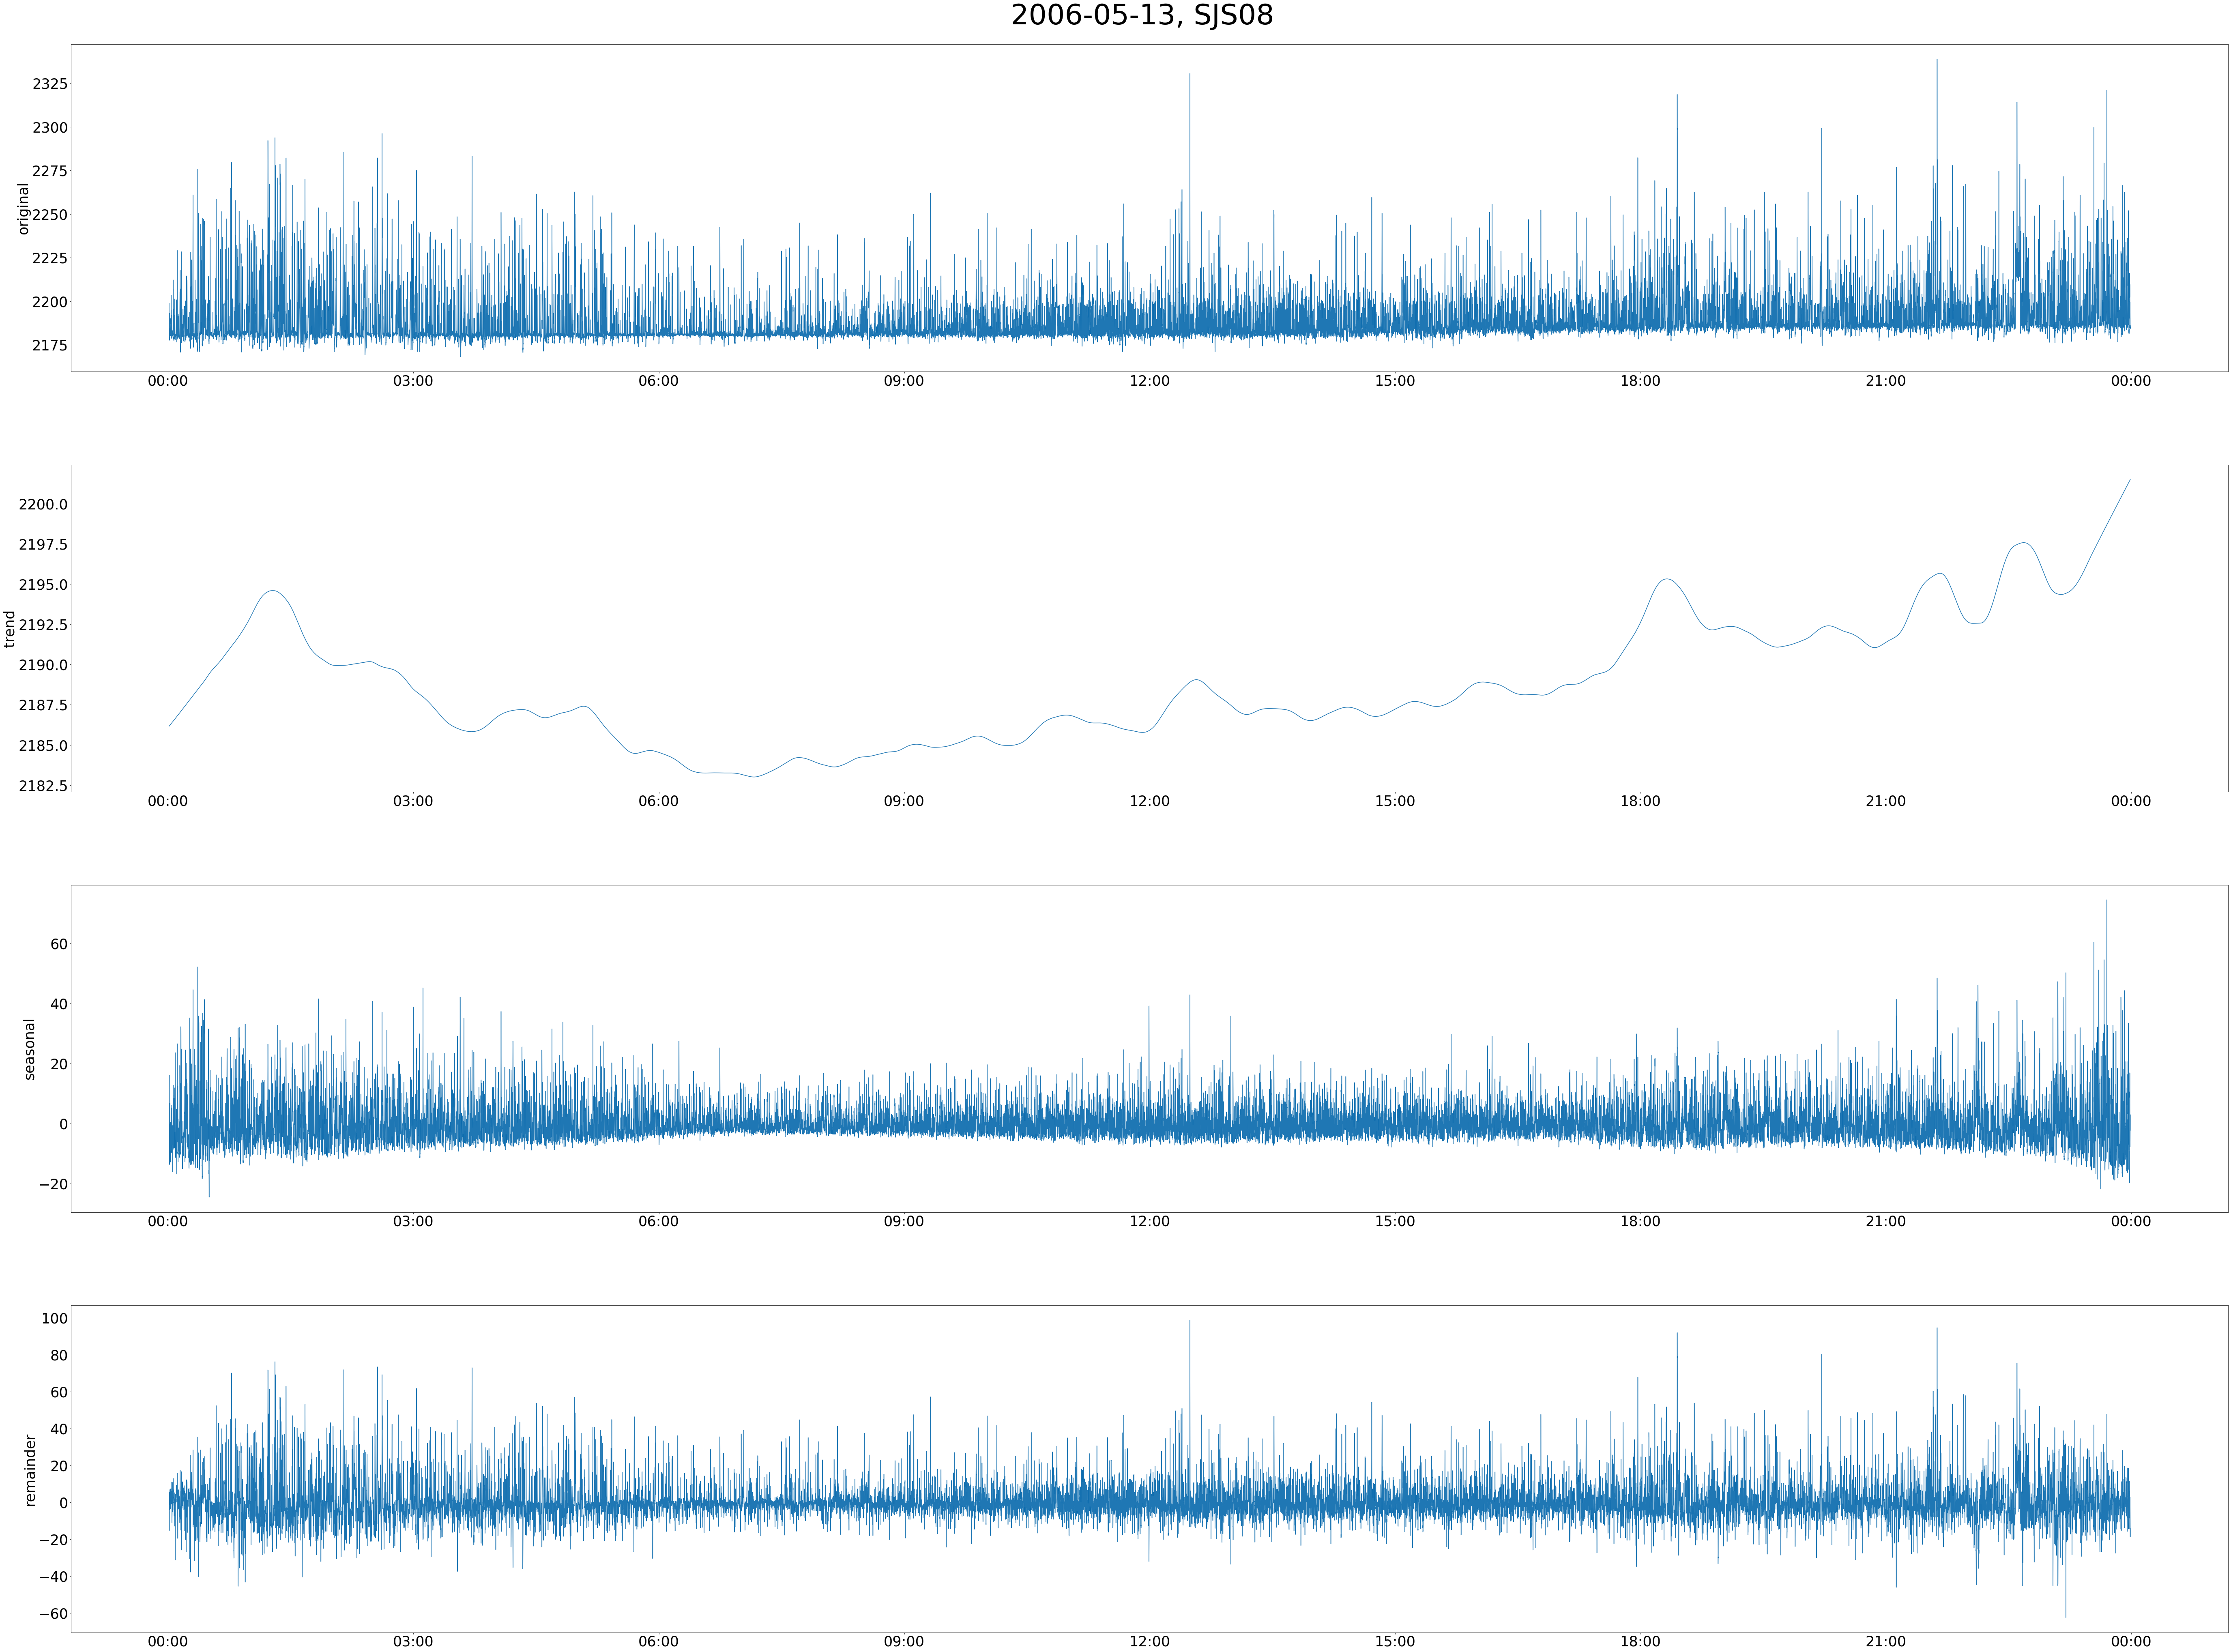

In [ ]:
# plot result of stl applied data of SJS08 on May 13, 2006
period = 3600
date_index = 0
read_and_plot_single_stl(period, date_index, 0)

['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13'

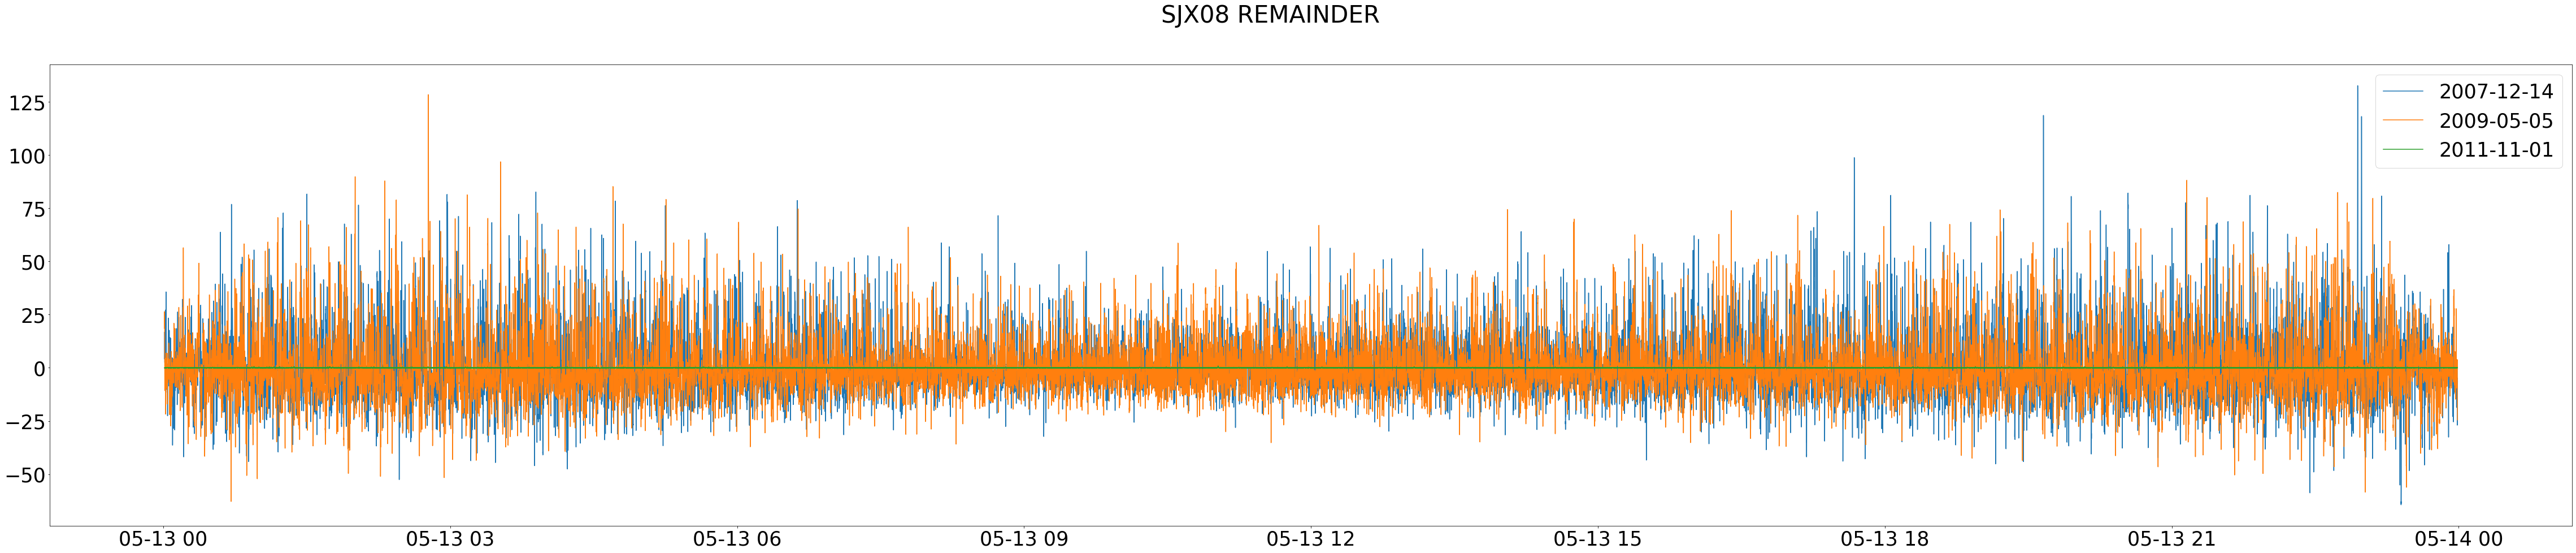

['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13', '2006-05-14', '2006-05-15', '2006-05-16', '2006-05-17', '2006-05-18', '2006-05-19', '2007-12-14', '2009-05-05', '2011-11-01']
['2006-05-13'

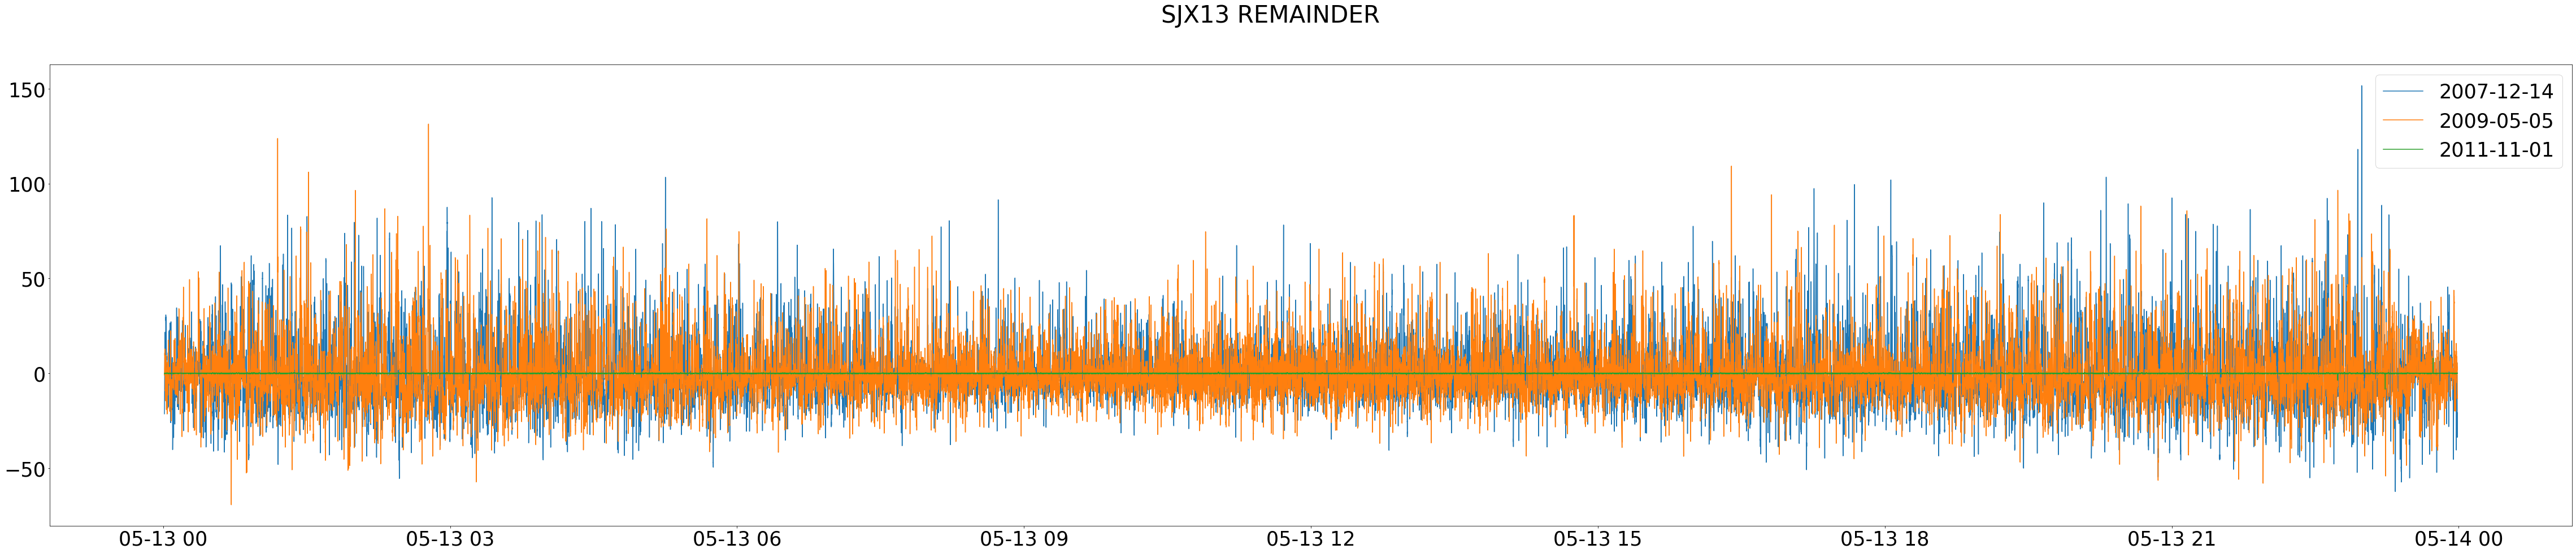

In [ ]:
# plot result of SJX08 and SJX13 of the stl remainder data on the last three days
period = 3600
plot_cable_stl_by_type(period, 7, STLType.REMAINDER, date_index_list=[7, 8, 9]) # SJX08
plot_cable_stl_by_type(period, 12, STLType.REMAINDER, date_index_list=[7, 8, 9]) # SJX13

### Cross-Correlation between cables

In [ ]:
# calculating all of cross-correlations among the cables on the last day
def get_cross_correlation(period, date_index, stl_type, start=0, end=length, cable_index_list=[i for i in range(14)]):
    str_date, cable_names, stl_df_list = read_day_stl(period, date_index)
    y_values = {}

    for i in cable_index_list:
        value = stl_df_list[i][start + 1:end + 1][STLType(stl_type).name.lower()].to_numpy()
        y_values[cable_names[i]] = value

    for i in range(len(cable_index_list)):
        cable_name_1 = cable_names[cable_index_list[i]]
        correlations = []
        for j in range(len(cable_index_list)):
            cable_name_2= cable_names[cable_index_list[j]]
            if cable_name_1 is cable_name_2: continue
            cross_correlation = np.correlate(np.asarray(y_values[cable_name_1]), np.asarray(y_values[cable_name_2]))
            print(cable_name_1, cable_name_2, cross_correlation)
            correlations.append(cross_correlation)
        print("mean:", sum(correlations) / float(len(correlations)))

def read_day_stl(period, date_index):
    date = ""
    cable_names = []
    stl_df_list = []
    for i in range(14):
        date, cable_name, stl_df = read_single_stl(period, date_index, i)
        cable_names.append(cable_name)
        stl_df_list.append(stl_df)

    return date, cable_names, stl_df_list

In [ ]:
period = 3600
date_indx = 9
get_cross_correlation(3600, date_index, STLType.REMAINDER)

SJS08 SJS09 [16386506.76076756]
SJS08 SJS10 [16089240.02570907]
SJS08 SJS11 [13633403.14843878]
SJS08 SJS12 [14141294.37238638]
SJS08 SJS13 [9181502.49923168]
SJS08 SJS14 [6934935.43513789]
SJS08 SJX08 [13887255.08301644]
SJS08 SJX09 [15116386.79529973]
SJS08 SJX10 [6515600.62108122]
SJS08 SJX11 [10855690.89704805]
SJS08 SJX12 [9109218.13560382]
SJS08 SJX13 [6875121.77133906]
SJS08 SJX14 [5050247.09893474]
mean: [11059723.28030726]
SJS09 SJS08 [16386506.76076756]
SJS09 SJS10 [20121898.83421633]
SJS09 SJS11 [18184005.79814395]
SJS09 SJS12 [20069823.07234158]
SJS09 SJS13 [13896789.48742961]
SJS09 SJS14 [11261264.03831217]
SJS09 SJX08 [15138376.07889455]
SJS09 SJX09 [17862270.29007079]
SJS09 SJX10 [8323446.23230221]
SJS09 SJX11 [14958563.68028836]
SJS09 SJX12 [13589770.78863798]
SJS09 SJX13 [11230464.85202365]
SJS09 SJX14 [9307389.2067102]
mean: [14640813.00924146]
SJS10 SJS08 [16089240.02570907]
SJS10 SJS09 [20121898.83421633]
SJS10 SJS11 [21726508.94675897]
SJS10 SJS12 [25396427.4042815